In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
from glob import glob
import seaborn as sns
import arviz as az
from os.path import join, split, splitext
from toolz import pipe
from fetch_data import create_arrays

In [2]:
# Directory containing model runs -- change as needed
run_dir = "./runs/fits/"

# Directory to save plots in -- change as needed
plot_dir = "./images"

# Find all runtime files:
all_runtimes = glob(join(run_dir, "*/*.txt"))

In [3]:
len(all_runtimes)

72

In [4]:
# Extract runtimes from text files
runtimes = [float(list(open(x))[0].strip()) for x in all_runtimes]

In [5]:
# Helper function to extract some more info from the filenames
def extract_info(filenames):
    approach_names = [x.split("/")[-2] for x in filenames]
    filenames = [split(splitext(x)[0])[-1] for x in filenames]
    years = [int(x.split("_")[-1]) for x in filenames]

    return {"year": years, "method": approach_names}

In [6]:
info = extract_info(all_runtimes)
info["runtime"] = runtimes

In [7]:
results = pd.DataFrame(info)

In [8]:
results.sort_values("year").head()

,year,method,runtime
4,1968,pymc_numpyro_gpu_parallel,362.580336
12,1968,pymc_blackjax_gpu_vectorized,153.056409
28,1968,cmdstanpy,776.482804
20,1968,pymc_numpyro_cpu_parallel,208.091710
52,1968,pymc_numpyro_cpu_vectorized,663.696737


In [9]:
# Fetch the number of data points for each year from the dataset
of_interest = results["year"].unique()

data = {x: create_arrays(x)["winner_ids"].shape[0] for x in of_interest}

/home/swami/Projects/tmp/mcmc_runtime_comparison/sackmann.py:82: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["round"].replace(round_numbers).infer_objects(copy=False)
/home/swami/Projects/tmp/mcmc_runtime_comparison/sackmann.py:82: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["round"].replace(round_numbers).infer_objects(copy=False)
/home/swami/Projects/tmp/mcmc_runtime_comparison/sackmann.py:82: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old b

In [10]:
results["n_matches"] = [data[row.year] for row in results.itertuples()]

In [11]:
total_matches = results["n_matches"].max()

In [12]:
results["log_matches"] = np.log10(results["n_matches"])

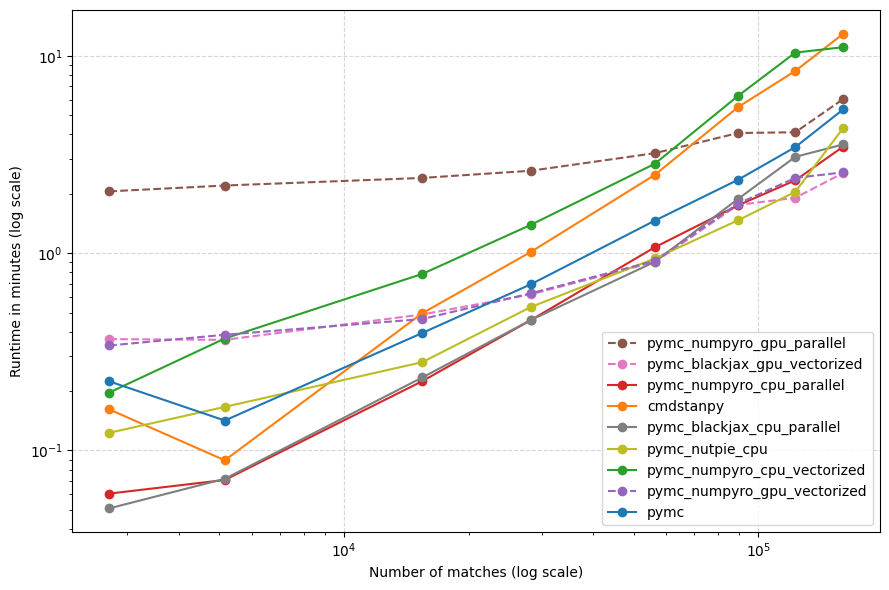

In [13]:
f, ax = plt.subplots(1, 1)

of_interest = [
    "pymc",
    "cmdstanpy",
    "pymc_numpyro_cpu_vectorized",
    "pymc_numpyro_cpu_parallel",
    "pymc_numpyro_gpu_vectorized",
    "pymc_numpyro_gpu_parallel",
    "pymc_blackjax_gpu_vectorized",
    "pymc_blackjax_cpu_parallel",
    "pymc_nutpie_cpu",
]

colours = sns.color_palette(palette=None, n_colors=len(of_interest))

colour_lookup = {x: y for x, y in zip(of_interest, colours)}

rel_results = results[results["method"].isin(of_interest)]

for cur_method in rel_results["method"].unique():
    cur_data = rel_results[rel_results["method"] == cur_method].sort_values("n_matches")

    linestyle = "--" if "gpu" in cur_method else None

    ax.plot(
        cur_data["n_matches"],
        cur_data["runtime"] / 60,
        label=cur_method,
        marker="o",
        linestyle=linestyle,
        color=colour_lookup[cur_method],
    )

ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel("Number of matches (log scale)")
ax.set_ylabel("Runtime in minutes (log scale)")

ax.grid(alpha=0.5, linestyle="--")

ax.legend(loc="lower right")

# ax.legend()

f.set_size_inches(9, 6)
f.tight_layout()

plt.savefig(join(plot_dir, "walltime_plot.png"), dpi=300)

/tmp/ipykernel_2071/2706652682.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


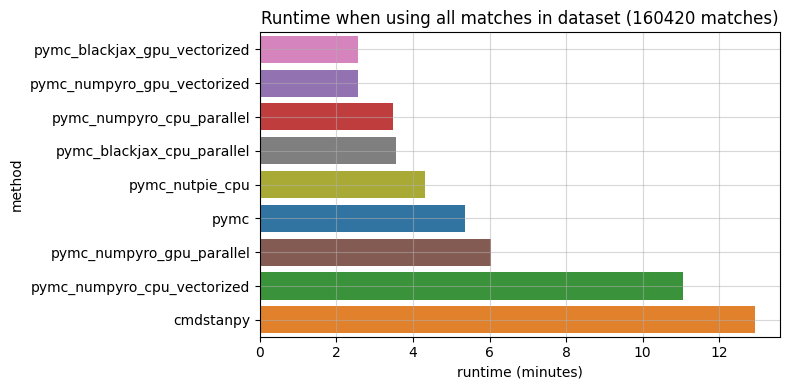

In [14]:
f, ax = plt.subplots(1, 1)

to_plot = rel_results[rel_results["n_matches"] == rel_results["n_matches"].max()].copy()

to_plot["runtime (minutes)"] = to_plot["runtime"] / 60

to_plot = to_plot.sort_values("runtime (minutes)")

colours_to_plot = [colour_lookup[x] for x in to_plot["method"]]

sns.barplot(
    x=to_plot["runtime (minutes)"], y=to_plot["method"], ax=ax, palette=colours_to_plot
)
ax.grid(alpha=0.5)

ax.set_title(f"Runtime when using all matches in dataset ({total_matches} matches)")

f.set_size_inches(8, 4)
f.tight_layout()

plt.savefig(join(plot_dir, "walltime_full.png"), dpi=300)

In [15]:
to_plot = to_plot.set_index("method", drop=False)

to_plot["runtime"] / to_plot["runtime"].min()

method
pymc_blackjax_gpu_vectorized    1.000000
pymc_numpyro_gpu_vectorized     1.006632
pymc_numpyro_cpu_parallel       1.359575
pymc_blackjax_cpu_parallel      1.394912
pymc_nutpie_cpu                 1.692156
pymc                            2.099751
pymc_numpyro_gpu_parallel       2.368933
pymc_numpyro_cpu_vectorized     4.336288
cmdstanpy                       5.073181
Name: runtime, dtype: float64

In [16]:
to_plot["runtime"] / 60

method
pymc_blackjax_gpu_vectorized     2.550940
pymc_numpyro_gpu_vectorized      2.567858
pymc_numpyro_cpu_parallel        3.468195
pymc_blackjax_cpu_parallel       3.558336
pymc_nutpie_cpu                  4.316589
pymc                             5.356340
pymc_numpyro_gpu_parallel        6.043006
pymc_numpyro_cpu_vectorized     11.061612
cmdstanpy                       12.941380
Name: runtime, dtype: float64

In [17]:
# Compute ESS / second

In [18]:
all_draws = glob(join(run_dir, "*/*.netcdf"))

In [19]:
def compute_min_ess(arviz_draws):
    min_ess = az.ess(arviz_draws).min()

    return float(min_ess.to_array().min().values)

In [20]:
min_ess = list(
    pipe(
        all_draws,
        # Load
        lambda x: map(az.from_netcdf, x),
        # Compute minimum ESS
        lambda x: map(compute_min_ess, x),
    )
)

In [21]:
draw_info = extract_info(all_draws)

In [22]:
ess_info = pd.DataFrame(
    {"min_ess": min_ess, "method": draw_info["method"], "year": draw_info["year"]}
)

In [23]:
with_runtime = ess_info.merge(results)

with_runtime["ESS / second"] = with_runtime["min_ess"] / with_runtime["runtime"]

In [24]:
with_runtime.head()

,min_ess,method,year,runtime,n_matches,log_matches,ESS / second
0,1251.279880,pymc_numpyro_gpu_parallel,2020,123.419908,2714,3.433610,10.138396
1,711.053172,pymc_numpyro_gpu_parallel,2015,144.353565,15464,4.189322,4.925775
2,561.764137,pymc_numpyro_gpu_parallel,1980,245.929533,122884,5.089495,2.284248
3,378.876310,pymc_numpyro_gpu_parallel,1968,362.580336,160420,5.205259,1.044944
4,335.460939,pymc_numpyro_gpu_parallel,2010,156.981700,28251,4.451034,2.136943


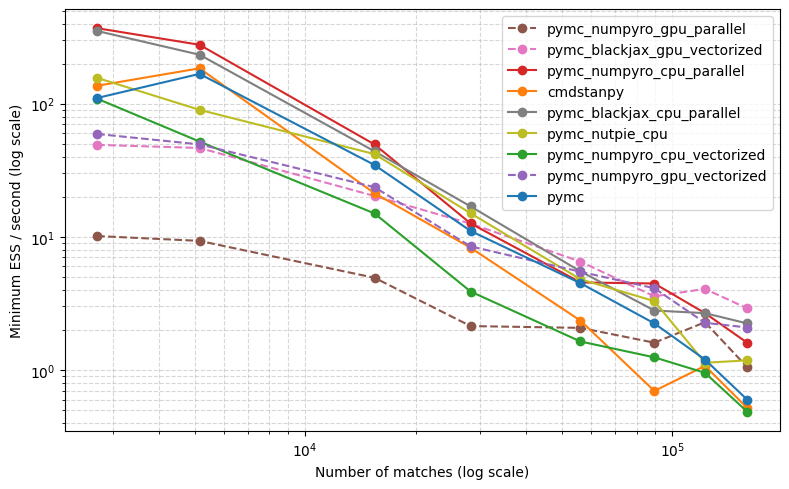

In [25]:
f, ax = plt.subplots(1, 1)

rel_results = with_runtime[with_runtime["method"].isin(of_interest)]

for cur_method in rel_results["method"].unique():
    cur_data = rel_results[rel_results["method"] == cur_method].sort_values("n_matches")

    linestyle = "--" if "gpu" in cur_method else None

    ax.plot(
        cur_data["n_matches"],
        cur_data["ESS / second"],
        label=cur_method,
        marker="o",
        linestyle=linestyle,
        color=colour_lookup[cur_method],
    )

ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel("Number of matches (log scale)")
ax.set_ylabel("Minimum ESS / second (log scale)")

ax.grid(alpha=0.5, linestyle="--", which="both")

ax.legend(loc="upper right")

f.set_size_inches(8, 5)
f.tight_layout()

plt.savefig(join(plot_dir, "ess_values.png"), dpi=300)

/tmp/ipykernel_2071/3352363523.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


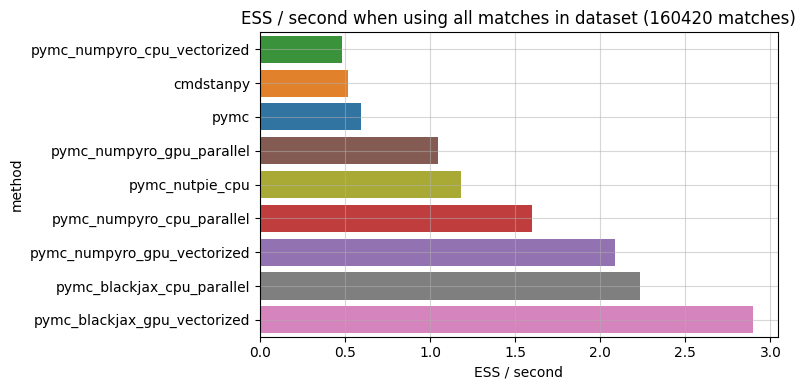

In [26]:
f, ax = plt.subplots(1, 1)

to_plot = rel_results[rel_results["year"] == 1968].sort_values("ESS / second")

colours_to_plot = [colour_lookup[x] for x in to_plot["method"]]

sns.barplot(
    x=to_plot["ESS / second"], y=to_plot["method"], ax=ax, palette=colours_to_plot
)

ax.grid(alpha=0.5)

ax.set_title(
    f"ESS / second when using all matches in dataset ({total_matches} matches)"
)

f.set_size_inches(8, 4)
f.tight_layout()

plt.savefig(join(plot_dir, "ess_per_second_full.png"), dpi=300)

In [27]:
rel = to_plot.set_index("method", drop=False)

rel["ESS / second"].max() / rel["ESS / second"]

method
pymc_numpyro_cpu_vectorized     5.985120
cmdstanpy                       5.606161
pymc                            4.864355
pymc_numpyro_gpu_parallel       2.773014
pymc_nutpie_cpu                 2.452280
pymc_numpyro_cpu_parallel       1.814424
pymc_numpyro_gpu_vectorized     1.389939
pymc_blackjax_cpu_parallel      1.296685
pymc_blackjax_gpu_vectorized    1.000000
Name: ESS / second, dtype: float64

In [28]:
11.3 / 3.9

2.897435897435898

In [29]:
# Check estimates agree

stan_res = az.from_netcdf(join(run_dir, "cmdstanpy/samples_1968.netcdf"))

In [30]:
list(stan_res.keys())

['posterior', 'sample_stats']

In [31]:
p_skills = stan_res.posterior["player_skills"]

player_means_stan = p_skills.values.mean(axis=(0, 1))
player_sds_stan = p_skills.values.std(axis=(0, 1))

In [32]:
pymc3_res = az.from_netcdf(join(run_dir, "pymc/samples_1968.netcdf"))

In [33]:
p_skills_pymc3 = pymc3_res.posterior["player_skills"].mean(dim=("chain", "draw"))
p_skills_pymc3_sd = pymc3_res.posterior["player_skills"].std(dim=("chain", "draw"))

In [34]:
# Load data for 1968 to get player names
cur_data = create_arrays(1968)

jax_res = az.from_netcdf(
    join(run_dir, "pymc_numpyro_gpu_vectorized/samples_1968.netcdf")
)

/home/swami/Projects/tmp/mcmc_runtime_comparison/sackmann.py:82: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["round"].replace(round_numbers).infer_objects(copy=False)


In [35]:
cur_data["player_encoder"]

LabelEncoder()

In [36]:
p_skills_jax = jax_res.posterior["player_skills"].mean(dim=("chain", "draw"))
p_skills_jax_sd = jax_res.posterior["player_skills"].std(dim=("chain", "draw"))

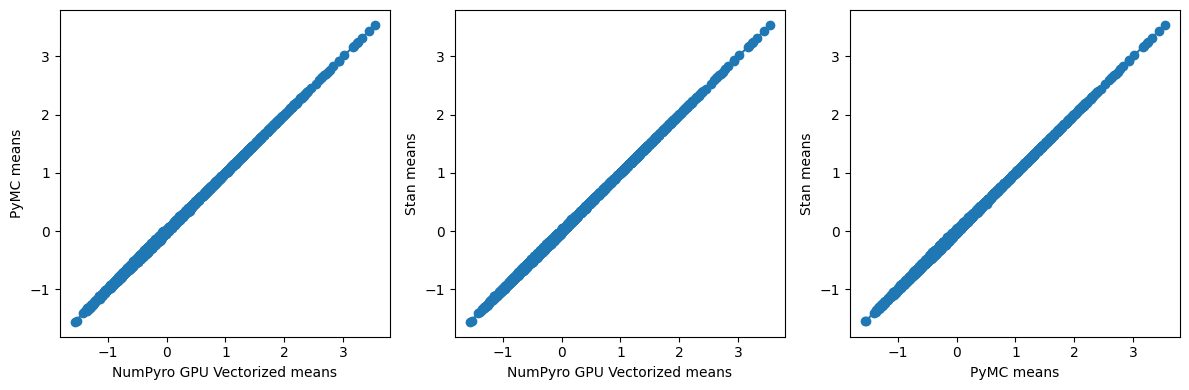

In [37]:
f, ax = plt.subplots(1, 3)

ax[0].scatter(p_skills_jax.values.reshape(-1), p_skills_pymc3.values.reshape(-1))
ax[0].plot(
    [p_skills_jax.min(), p_skills_jax.max()], [p_skills_jax.min(), p_skills_jax.max()]
)

ax[1].scatter(p_skills_jax.values.reshape(-1), player_means_stan.reshape(-1))
ax[1].plot(
    [p_skills_jax.min(), p_skills_jax.max()], [p_skills_jax.min(), p_skills_jax.max()]
)

ax[2].scatter(p_skills_pymc3.values.reshape(-1), player_means_stan.reshape(-1))
ax[2].plot(
    [p_skills_pymc3.min(), p_skills_pymc3.max()],
    [p_skills_pymc3.min(), p_skills_pymc3.max()],
)

ax[0].set_xlabel("NumPyro GPU Vectorized means")
ax[0].set_ylabel("PyMC means")

ax[1].set_xlabel("NumPyro GPU Vectorized means")
ax[1].set_ylabel("Stan means")

ax[2].set_xlabel("PyMC means")
ax[2].set_ylabel("Stan means")

f.set_size_inches(12, 4)
f.tight_layout()

plt.savefig(join(plot_dir, "mean_comparison.png"), dpi=300)

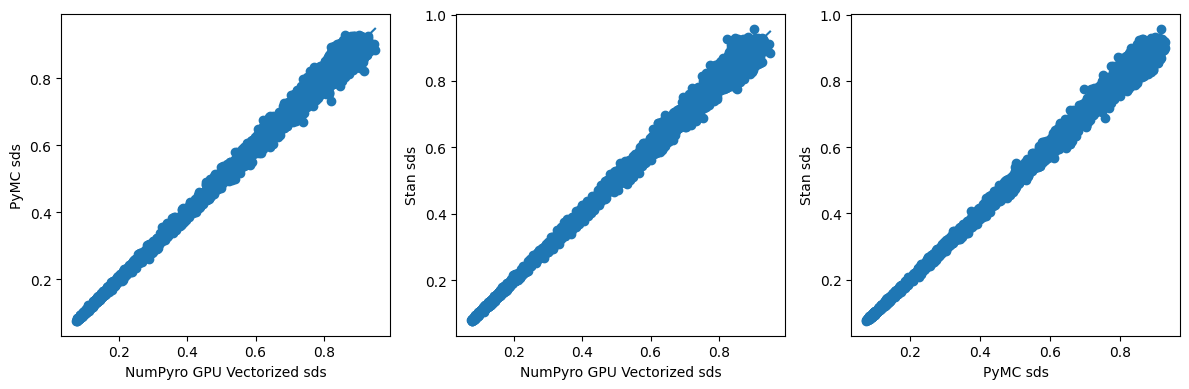

In [38]:
f, ax = plt.subplots(1, 3)

ax[0].scatter(p_skills_jax_sd.values.reshape(-1), p_skills_pymc3_sd.values.reshape(-1))
ax[0].plot(
    [p_skills_jax_sd.min(), p_skills_jax_sd.max()],
    [p_skills_jax_sd.min(), p_skills_jax_sd.max()],
)

ax[1].scatter(p_skills_jax_sd.values.reshape(-1), player_sds_stan.reshape(-1))
ax[1].plot(
    [p_skills_jax_sd.min(), p_skills_jax_sd.max()],
    [p_skills_jax_sd.min(), p_skills_jax_sd.max()],
)

ax[2].scatter(p_skills_pymc3_sd.values.reshape(-1), player_sds_stan.reshape(-1))
ax[2].plot(
    [p_skills_pymc3_sd.min(), p_skills_pymc3_sd.max()],
    [p_skills_pymc3_sd.min(), p_skills_pymc3_sd.max()],
)

ax[0].set_xlabel("NumPyro GPU Vectorized sds")
ax[0].set_ylabel("PyMC sds")

ax[1].set_xlabel("NumPyro GPU Vectorized sds")
ax[1].set_ylabel("Stan sds")

ax[2].set_xlabel("PyMC sds")
ax[2].set_ylabel("Stan sds")

f.set_size_inches(12, 4)
f.tight_layout()

plt.savefig(join(plot_dir, "sd_comparison.png"), dpi=300)

In [39]:
p_skills.shape

(4, 1000, 4804)

In [40]:
p_skills_jax.shape

(4804,)

In [41]:
print(
    pd.DataFrame(
        {"mean_skill": p_skills_jax, "skill_sd": p_skills_jax_sd},
        index=cur_data["player_encoder"].classes_,
    )
    .sort_values("mean_skill", ascending=False)
    .head(20)
    .round(2)
    # .to_markdown()
)

                       mean_skill  skill_sd
Novak Djokovic               3.54      0.09
Rafael Nadal                 3.43      0.09
Roger Federer                3.31      0.08
Bjorn Borg                   3.25      0.11
Ivan Lendl                   3.23      0.08
John McEnroe                 3.18      0.09
Jimmy Connors                3.16      0.08
Rod Laver                    3.01      0.11
Andy Murray                  2.92      0.10
Pete Sampras                 2.92      0.09
Boris Becker                 2.83      0.09
Andre Agassi                 2.77      0.08
Stefan Edberg                2.73      0.08
Andy Roddick                 2.70      0.09
Juan Martin del Potro        2.68      0.11
Arthur Ashe                  2.65      0.09
Ken Rosewall                 2.62      0.10
Guillermo Vilas              2.59      0.08
John Newcombe                2.53      0.10
Mats Wilander                2.44      0.09
